In [1]:
import sys
sys.path.append("./")

In [2]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [3]:
tf.random.set_seed(1)

In [4]:
class LimitingDistribution:
    def __init__(self, init_log_prob, target_log_prob, nu):
        self.init_log_prob = init_log_prob
        self.target_log_prob = target_log_prob
        self.nu = nu
        
    def log_prob(self, x, k=100):
        xp = tf.expand_dims(x, axis=0) + tf.cast(
            self.nu * tf.reshape(
                tf.linspace(-k//2, k//2, k+1), 
                (-1, 1, 1),
            ), 
            dtype=tf.float32
        )
        
        term1 = self.target_log_prob(x) # n, 1
        
        weight_numerator = self.init_log_prob(xp) # k, n, 1
        weight_numerator = tf.math.reduce_logsumexp(weight_numerator, axis=0) # n, 1
        
        weight_denom = self.target_log_prob(xp) # k, n, 1
        weight_denom = tf.math.reduce_logsumexp(weight_denom, axis=0) # n, 1
        
        log_prob = term1 + weight_numerator - weight_denom # n, 1
        
        return log_prob
        

In [5]:
dim = 1 # has to be 1

## mixure of gaussians
k = 1
delta = 10.
shift = 0. # [- delta / 2]
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_sample)


2023-01-11 21:51:08.023174: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-11 21:51:08.023224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2023-01-11 21:51:08.023231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2023-01-11 21:51:08.023354: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2023-01-11 21:51:08.023382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2023-01-11 21:51:08.023388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2023-01-11 21:51:08.024297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [6]:
target_sample = target.sample(1000)
proposal_sample = proposal_off.sample(1000)

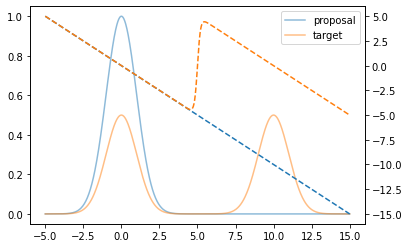

In [7]:
xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

with tf.GradientTape() as g:
    g.watch(xx)
    lp = log_prob_fn(xx)
score_target = g.gradient(lp, xx)

with tf.GradientTape() as g:
    g.watch(xx)
    lp = log_prob_off_fn(xx)
score_proposal = g.gradient(lp, xx)

fig, ax1 = plt.subplots()
ax1.plot(xx.numpy(), tf.math.exp(log_prob_off_fn(xx)).numpy(), label="proposal", alpha=0.5)
ax1.plot(xx.numpy(), tf.math.exp(log_prob_fn(xx)).numpy(), label="target", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(xx.numpy(), score_proposal.numpy(), linestyle="--")
ax2.plot(xx.numpy(), score_target.numpy(), linestyle="--")

ax1.legend()
plt.show()

In [21]:
def plot_scores(log_prob_fn, log_prob_off_fn, dist_class, nu_delta_ratios, delta, nrows, ncols, plot_diff=False,
               ylims1=(-0.05, 1.1), ylims2=(-15., 10.), plot_sample_density=False):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # target
        limiting_target = dist_class(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, xx)
        
        # proposal
        limiting_proposal = dist_class(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, xx)
        
        # score differences
        score_diff = tf.reshape(
            tf.math.abs(score_target - score_proposal),
            (-1,),
        )
        
        # density
        axes[j//ncols][j%ncols].plot(xx, prob_target, label="target")
        axes[j//ncols][j%ncols].plot(xx, prob_proposal, label="proposal")
        axes[j//ncols][j%ncols].set_ylim(ylims1[0], ylims1[1])
        
        # score
        ax_twin = axes[j//ncols][j%ncols].twinx()
        if not plot_diff:
            ax_twin.plot(xx, score_target, linestyle="--")
            ax_twin.plot(xx, score_proposal, linestyle="--")
            ax_twin.set_ylim(ylims2[0], ylims2[1])
        else:
            ax_twin.plot(xx, score_diff, linestyle="--", color="red", label="abs score diff")
            ax_twin.set_ylim(-15, 8.)
    
        axes[j//ncols][j%ncols].set_title(f"gamma = {np.round(ratio, 3)}")
        
        # density of sample distribution
        if plot_sample_density:
            proposal_prob = tf.exp(log_prob_off_fn(xx))
            axes[j//ncols][j%ncols].plot(xx, proposal_prob, color="grey", label="proposal unpert")
            axes[j//ncols][j%ncols].fill_between(tf.squeeze(xx), proposal_prob, color="silver")
    
    axes[0][0].legend()
    plt.tight_layout()

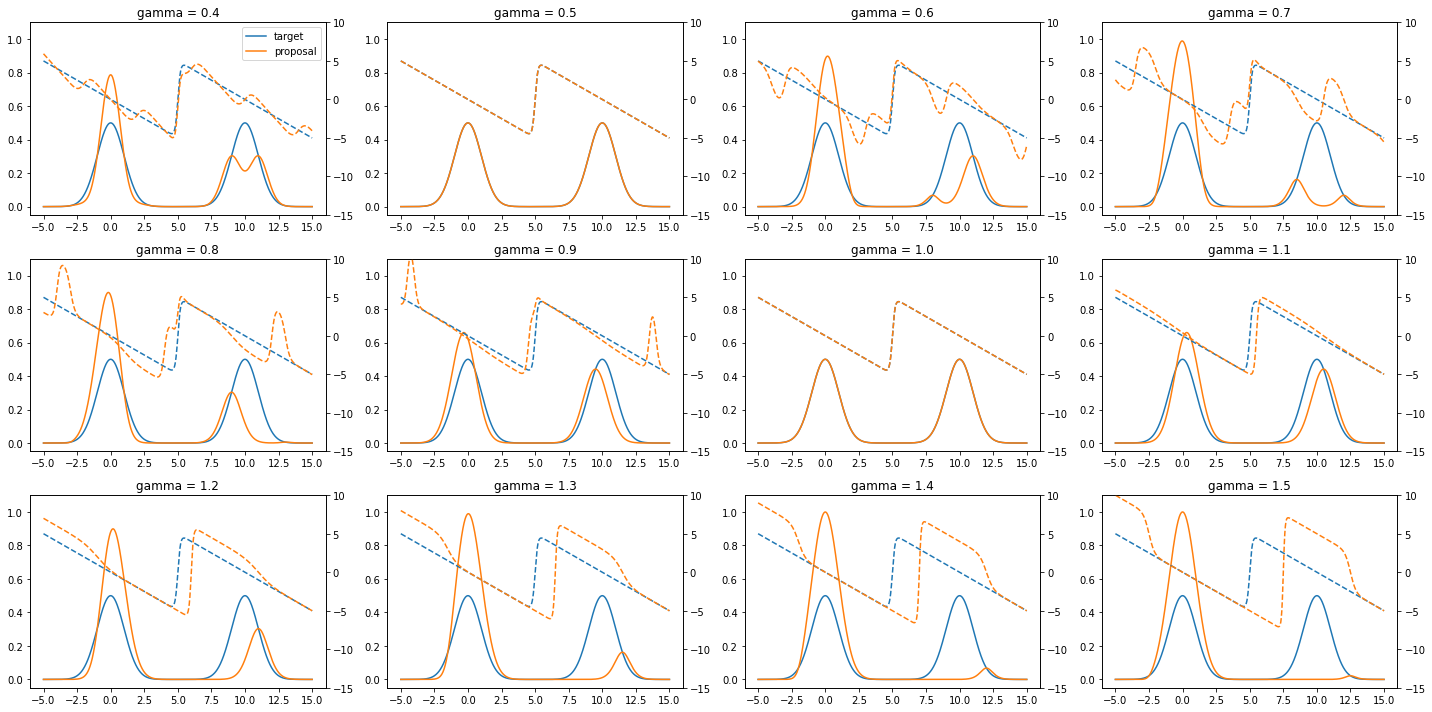

In [15]:
# nu_delta_ratios = list(np.linspace(0.05, 0.4, 12))
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plot_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn,
    dist_class=LimitingDistribution,
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=3, 
    ncols=4,
    ylims2=[-15., 10.],
#     plot_sample_density=True,
)

In [17]:
# nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

# plot_scores(
#     log_prob_fn=log_prob_fn, 
#     log_prob_off_fn=log_prob_off_fn, 
#     nu_delta_ratios=nu_delta_ratios,
#     delta=delta,
#     nrows=3, 
#     ncols=4,
#     plot_diff=True,
# )

In [19]:
def plot_weighted_scores(log_prob_fn, log_prob_off_fn, dist_class, nu_delta_ratios, delta, nrows, ncols):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))
    delta_x = xx[1, 0] - xx[0, 0]
    fisher_div_list = []
    
    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # target
        limiting_target = dist_class(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, xx)
        
        # proposal
        limiting_proposal = dist_class(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, xx)
        
        # weighted score differences
        weighted_score_diff = prob_proposal * tf.reshape(
            tf.math.abs(score_target - score_proposal),
            (-1,),
        )
        
        # Fisher div
        fisher_div = tf.math.reduce_sum(weighted_score_diff[:-2] * delta_x)
        fisher_div_list.append(fisher_div)

        # plot
        axes[j//ncols][j%ncols].plot(
            xx, weighted_score_diff, linestyle="--", color="red", label="weighted score diff",
        )
        axes[j//ncols][j%ncols].set_ylim(-.05, 0.5)
        axes[j//ncols][j%ncols].set_title(f"nu / Delta = {np.round(ratio, 3)}")
    
    axes[0][0].legend()
    plt.tight_layout()
    plt.show()


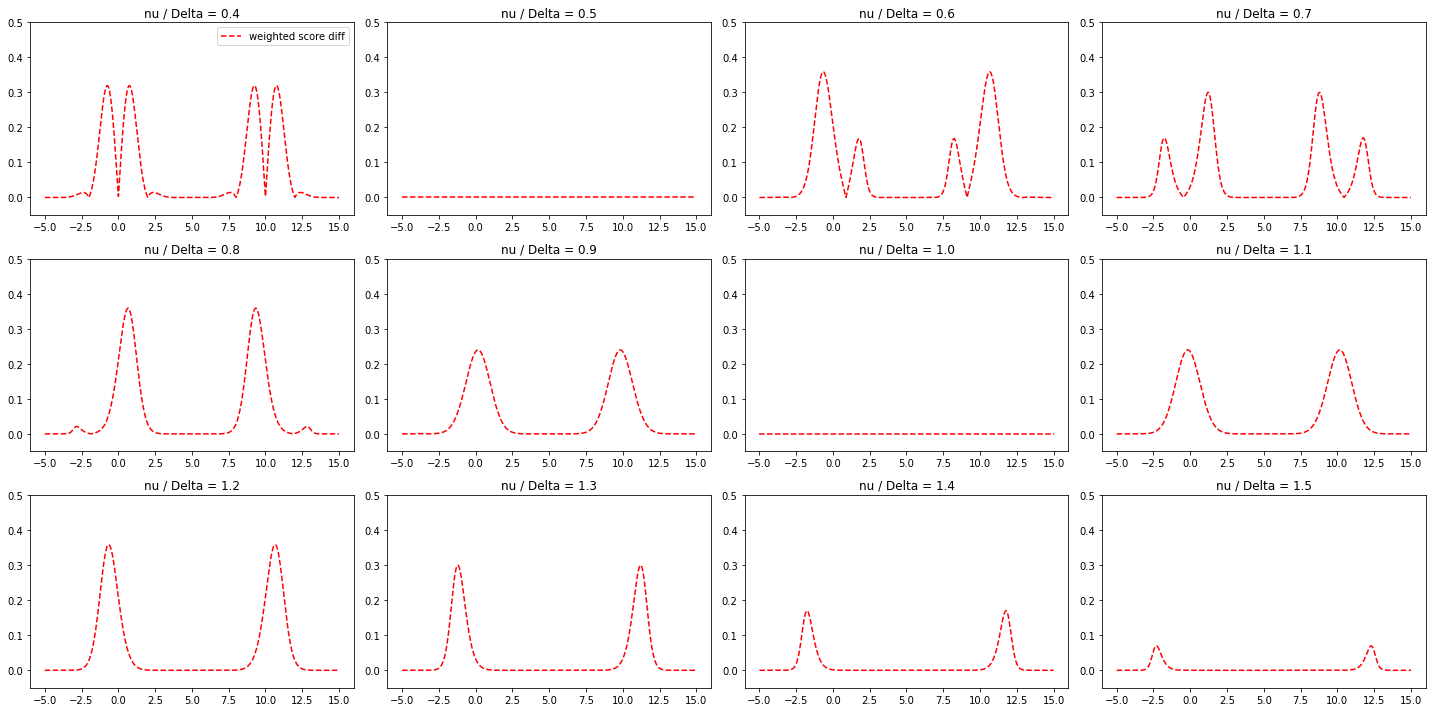

In [20]:
nu_delta_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plot_weighted_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn,
    dist_class=LimitingDistribution,
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=3, 
    ncols=4,
)

In [8]:
def plot_discrepancy(
    log_prob_fn, log_prob_off_fn, proposal_sample, dist_class,
     nu_delta_ratios, delta, proposal_dict, ind_pair_list,
     T=1000, plot=True,
):
    delta_x = xx[1, 0] - xx[0, 0]
    fisher_div_list = []
    ksd_list = []
    accept_rate_list = []
    
    # perturb
    mh = mcmc.RandomWalkMH(log_prob=log_prob_fn)
    mh.run(steps=T, std=nu_delta_ratios, x_init=proposal_sample, ind_pair_list=ind_pair_list, **proposal_dict)
    
    # compute KSD of un-perturbed
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(kernel=kernel, log_prob=log_prob_fn)
    x_0 = mh.x[0, 0]
    ksd_val_unpert = ksd(x_0, tf.identity(x_0))
    
    for j, ratio in enumerate(nu_delta_ratios):
        nu = ratio * delta
        
        # get perturbed data
        x_t = mh.x[j, -1]

        # 1. compute KSD
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(kernel=kernel, log_prob=log_prob_fn)
        ksd_val = ksd(x_t, tf.identity(x_t))
        ksd_list.append(ksd_val)
        
        # 2. compute Fisher div
        # target
        limiting_target = dist_class(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(x_t)
            lp_target = limiting_target.log_prob(x_t)
        prob_target = tf.math.exp(lp_target)
        score_target = g.gradient(lp_target, x_t)
        
        # proposal
        limiting_proposal = dist_class(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(x_t)
            lp_proposal = limiting_proposal.log_prob(x_t)
        prob_proposal = tf.math.exp(lp_proposal)
        score_proposal = g.gradient(lp_proposal, x_t)
        
        # Fisher div
        fisher_div = tf.math.reduce_mean(
            (score_target - score_proposal)**2,
        )
        fisher_div_list.append(fisher_div)
        
    if not plot:
        return ksd_val_unpert, ksd_list, fisher_div_list
        
    # plot
    figs, axes = plt.subplots(1, 2, figsize=(12, 4))

    pl1 = axes[0].plot(nu_delta_ratios, ksd_list, marker=".", markersize=12, label="pKSD")
    pl1 = axes[0].plot(nu_delta_ratios, fisher_div_list, marker=".", markersize=12, label="Fisher divergence")
    axes[0].axhline(ksd_val_unpert, color="grey", linestyle="dashed", label="pKSD unperturbed")
    axes[0].set_xlabel("nu / Delta", fontsize=18)
    axes[0].set_ylabel("Divergence", fontsize=18)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[0].legend(fontsize=16, loc="upper right")

#     ax_twin = ax.twinx()
#     pl2 = ax_twin.plot(
#         nu_delta_ratios, fisher_div_list, linestyle="--", color="red", marker=".", label="Fisher divergence"
#     )
#     ax_twin.set_ylabel("Fisher divergence", fontsize=18)
#     ax_twin.yaxis.set_tick_params(labelsize=18)

#     lns = pl1 + pl2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs)
    
    # acceptance rate
    accept_rate = tf.math.reduce_mean(mh.if_accept, axis=[1, 2])
    axes[1].plot(nu_delta_ratios, accept_rate, marker=".", markersize=12, color="k")
    axes[1].set_xlabel("nu / Delta", fontsize=18)
    axes[1].set_ylabel("Average acceptance rate", fontsize=18)

    plt.tight_layout()
    plt.show()

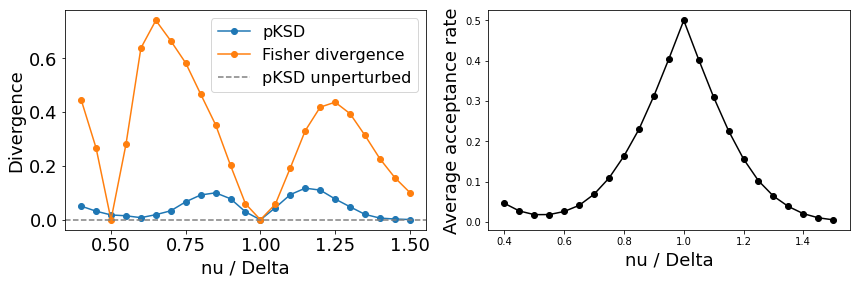

In [81]:
# modes and hess
mode_list = [tf.constant([0.]), tf.constant([delta])]
inv_hess_list = [tf.eye(1), tf.eye(1)]

proposal_dict = mcmc.prepare_proposal_input_all(
    mode_list=mode_list,
    inv_hess_list=inv_hess_list,
)

_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

# ratios
nu_delta_ratios = [float(x) for x in np.linspace(0.4, 1.5, 23)]

plot_discrepancy(
    log_prob_fn=log_prob_fn,
    log_prob_off_fn=log_prob_off_fn,
    proposal_sample=proposal_sample,
    dist_class=LimitingDistribution,
    nu_delta_ratios=nu_delta_ratios, 
    delta=delta, 
    proposal_dict=proposal_dict, 
    ind_pair_list=ind_pair_list,
    T=1000,
)

# Confirming the alternative view that pKSD compares the two distributions through their infinite superposition

In [18]:
class SuperpositionDistribution:
    def __init__(self, init_log_prob, target_log_prob, nu):
        self.init_log_prob = init_log_prob
        self.nu = nu
        
    def log_prob(self, x, k=100):
        xp = tf.expand_dims(x, axis=0) + tf.cast(
            self.nu * tf.reshape(
                tf.linspace(-k//2, k//2, k+1), 
                (-1, 1, 1),
            ), 
            dtype=tf.float32
        )
        
        log_prob = self.init_log_prob(xp) # k, n, 1
        log_prob = tf.math.reduce_logsumexp(log_prob, axis=0) # n, 1
        
        return log_prob
    
    def prob(self, x, k=100):
        xp = tf.expand_dims(x, axis=0) + tf.cast(
            self.nu * tf.reshape(
                tf.linspace(-k//2, k//2, k+1), 
                (-1, 1, 1),
            ), 
            dtype=tf.float32
        )
        
        prob = tf.exp(self.init_log_prob(xp)) # k, n, 1
        prob = tf.math.reduce_sum(prob, axis=0) # n, 1
        return prob

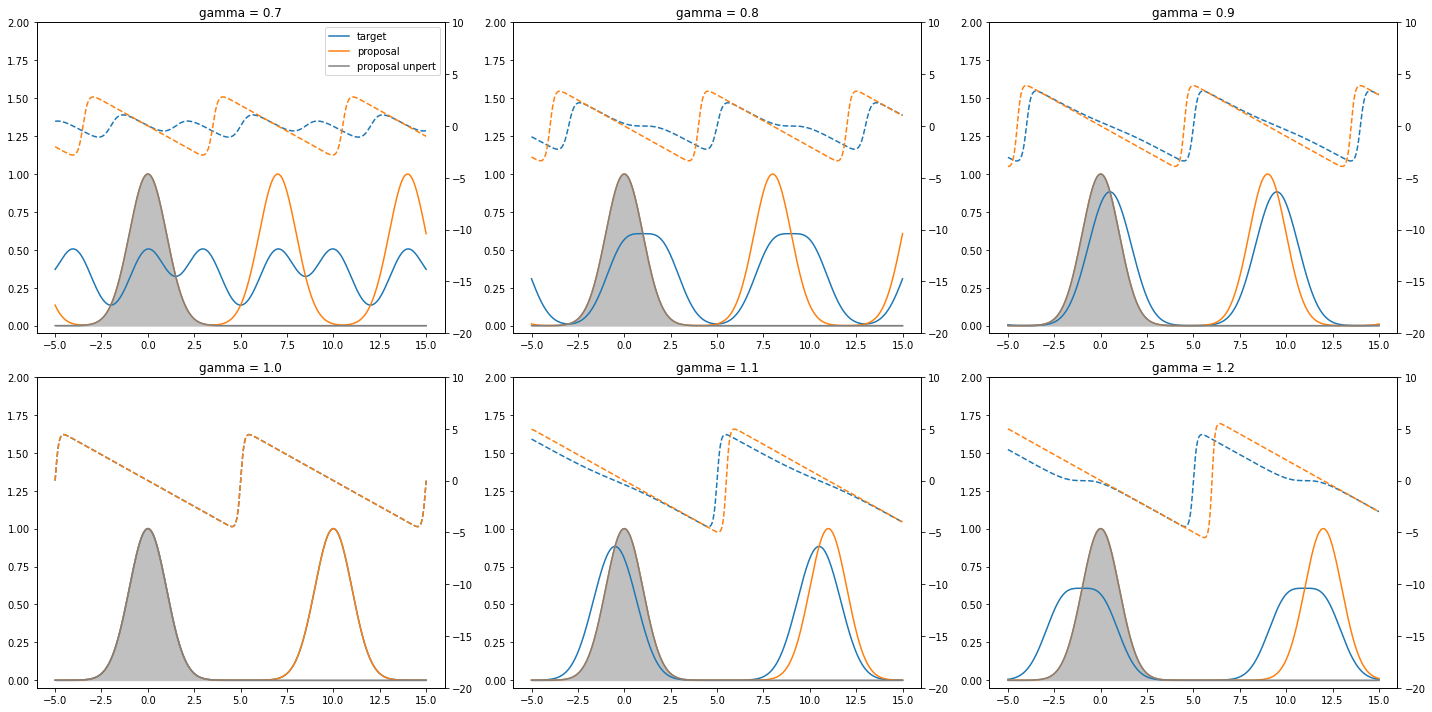

In [19]:
nu_delta_ratios = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

plot_scores(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn,
    dist_class=SuperpositionDistribution,
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    nrows=2, 
    ncols=3,
    ylims1=[-0.05, 2.],
    ylims2=[-20., 10.],
    plot_sample_density=True,
)

In [9]:
# compute ksd
mode_list = [tf.constant([0.]), tf.constant([delta])]
inv_hess_list = [tf.eye(1), tf.eye(1)]

proposal_dict = mcmc.prepare_proposal_input_all(
    mode_list=mode_list,
    inv_hess_list=inv_hess_list,
)

_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

# ratios
nu_delta_ratios = [float(x) for x in np.linspace(0.4, 1.5, 23)]

ksd_list, pksd_list, fd_list = plot_discrepancy(
    log_prob_fn=log_prob_fn,
    log_prob_off_fn=log_prob_off_fn,
    proposal_sample=proposal_sample,
    dist_class=LimitingDistribution,
    nu_delta_ratios=nu_delta_ratios, 
    delta=delta, 
    proposal_dict=proposal_dict, 
    ind_pair_list=ind_pair_list,
    T=1000,
    plot=False,
)

In [10]:
def plot_scores2(log_prob_fn, log_prob_off_fn, dist_class, nu_delta_ratios_short, nu_delta_ratios, delta, 
                 ksd_list, pksd_list, fd_list,
                 nrows=1, ncols=3, 
                 plot_diff=False,
                 ylims1=(-0.05, 1.1), ylims2=(-15., 10.), plot_sample_density=False):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

    figs, axes = plt.subplots(nrows, ncols, figsize=(12, 3))
    for j, ratio in enumerate(nu_delta_ratios_short):
        nu = ratio * delta
        
        # target
        limiting_target = dist_class(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        
        score_target = g.gradient(lp_target, xx)
#         prob_target = limiting_target.prob(xx)
        prob_target = tf.exp(lp_target)
        
        # proposal
        limiting_proposal = dist_class(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        
        score_proposal = g.gradient(lp_proposal, xx)
#         prob_proposal = limiting_proposal.prob(xx)
        prob_proposal = tf.exp(lp_proposal)

        # score differences
        score_diff = tf.reshape(
            score_proposal - score_target,
            (-1,),
        )
        # weighted score differences
        weighted_score_diff = tf.reshape(
            tf.exp(log_prob_off_fn(xx)), (-1,)
        ) * score_diff
        
        # density differences
        prob_diff = tf.reshape(
            prob_proposal - prob_target,
            (-1,),
        )

        # density
        axes[j%ncols].plot(xx, prob_target, label=r"$\phi_p$")
        axes[j%ncols].plot(xx, prob_proposal, label=r"$\phi_q$")
#         axes[j%ncols].plot(xx, prob_diff, label="prob diff")
        axes[j%ncols].set_ylim(ylims1[0], ylims1[1])
        axes[j%ncols].set_xlabel("$x$", fontsize=18)
        axes[j%ncols].set_ylabel("Density", fontsize=18)
        axes[j%ncols].set_title(f"$\theta = {np.round(ratio, 3)}$", fontsize=18)
        axes[j%ncols].xaxis.set_tick_params(labelsize=18)
        axes[j%ncols].yaxis.set_tick_params(labelsize=18)
        if j != 0:
            axes[j%ncols].get_yaxis().set_visible(False)
        
        # score
        ax_twin = axes[j%ncols].twinx()
        ax_twin.plot(xx, score_target, linestyle="--")
        ax_twin.plot(xx, score_proposal, linestyle="--")
#         ax_twin.plot(xx, score_diff, label="weighted score diff", linestyle="--")
        ax_twin.set_ylim(ylims2[0], ylims2[1])
        ax_twin.set_ylabel("Gradient of logarithms", fontsize=18)
        ax_twin.yaxis.set_tick_params(labelsize=18)
        if j != ncols-1:
            ax_twin.get_yaxis().set_visible(False)
        
        # density of sample distribution
        if plot_sample_density:
            proposal_prob = tf.exp(log_prob_off_fn(xx))
            axes[j%ncols].plot(xx, proposal_prob, color="grey", label="$q$")
            axes[j%ncols].fill_between(tf.squeeze(xx), proposal_prob, color="silver")
    
    axes[0].legend(
        loc="upper center", bbox_to_anchor=(1.7, 1.42), ncol=3, #fancybox=True, #shadow=True,
        fontsize=18,
    )
    plt.show()
    figs.savefig("./figs/paper/densities_vs_gamma.pdf", bbox_inches="tight")
    
    # divergences
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.axhline(ksd_list, color="grey", linestyle="dashed", label=r"KSD $\mathbb{D}(Q, P)$")
    ax.plot(nu_delta_ratios, pksd_list, marker=".", markersize=12,
            label=r"pKSD $\mathbb{D}(\mathcal{K}^{\infty} Q, P)$",
   )
#     ax.plot(nu_delta_ratios, fd_list, marker="x", markersize=10, label="FD")
    ax.set_xlabel("$\theta$", fontsize=18)
    ax.set_ylabel("") # "Divergence"
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.legend(
        loc="upper center", bbox_to_anchor=(1.4, 1.), #fancybox=True, #shadow=True,
        fontsize=18,
    )
    fig.savefig("./figs/paper/div_vs_gamma.pdf", bbox_inches="tight")

In [11]:
nu_delta_ratios_short = [0.8, 1.0, 1.2]
nu_delta_ratios = [float(x) for x in np.linspace(0.4, 1.5, 23)]

plot_scores2(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn,
    dist_class=SuperpositionDistribution,
    nu_delta_ratios_short=nu_delta_ratios_short,
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    ksd_list=ksd_list,
    pksd_list=pksd_list,
    fd_list=fd_list,
    ylims1=[-0.05, 2.],
    ylims2=[-20., 10.],
#     ylims1=[-1., 2.],
#     ylims2=[-4., 1.],
    plot_sample_density=True,
)

NameError: name 'SuperpositionDistribution' is not defined

In [18]:
def plot_scores3(log_prob_fn, log_prob_off_fn, dist_class, nu_delta_ratios_short, nu_delta_ratios, delta, 
                 ksd_list, pksd_list, fd_list,
                 nrows=2, ncols=3, 
                 plot_diff=False,
                 ylims1=(-0.05, 1.1), ylims2=(-15., 10.), plot_sample_density=False):
    xx = tf.reshape(tf.linspace(-5., delta+5., 1000), (-1, 1))

    figs, axes = plt.subplots(nrows, ncols, figsize=(12, 3))
    for j, ratio in enumerate(nu_delta_ratios_short):
        nu = ratio * delta
        
        # target
        limiting_target = dist_class(log_prob_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_target = limiting_target.log_prob(xx)
        
        score_target = g.gradient(lp_target, xx)
#         prob_target = limiting_target.prob(xx)
        prob_target = tf.exp(lp_target)
        
        # proposal
        limiting_proposal = dist_class(log_prob_off_fn, log_prob_fn, nu)
        
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal = limiting_proposal.log_prob(xx)
        
        score_proposal = g.gradient(lp_proposal, xx)
#         prob_proposal = limiting_proposal.prob(xx)
        prob_proposal = tf.exp(lp_proposal)
    
        # proposal original
        with tf.GradientTape() as g:
            g.watch(xx)
            lp_proposal_raw = log_prob_off_fn(xx)
        
        score_proposal_raw = g.gradient(lp_proposal_raw, xx)

        # score differences
        score_diff = tf.reshape(
            score_proposal - score_target,
            (-1,),
        )
        # weighted score differences
        weighted_score_diff = tf.reshape(
            tf.exp(log_prob_off_fn(xx)), (-1,)
        ) * score_diff
        
        # density differences
        prob_diff = tf.reshape(
            prob_proposal - prob_target,
            (-1,),
        )

        # density
        ax1 = axes[0][j%ncols]
        ax1.plot(xx, prob_target, linewidth=4, label=r"$p$")
        
        proposal_prob = tf.exp(log_prob_off_fn(xx))
        ax1.plot(xx, proposal_prob, linewidth=3, color="grey", label="$q$")
#         ax1.fill_between(tf.squeeze(xx), proposal_prob, color="silver")
        
        ax1.plot(xx, prob_proposal, linewidth=3, label=r"$q^\infty$", linestyle="--")
        
        ax1.set_ylim(ylims1[0], ylims1[1])
        ax1.set_ylabel("Density", fontsize=18)
        ax1.set_title(fr"$\theta = {np.round(ratio, 3)}$", fontsize=22)
        ax1.yaxis.set_tick_params(labelsize=18)
        ax1.tick_params(
            axis="x",          # changes apply to the x-axis
            which="both",      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False, # labels along the bottom edge are off
        )
        if j != 0:
            ax1.get_yaxis().set_visible(False)
        
        # score
        ax2 = axes[1][j%ncols]
        ax2.plot(xx, score_target, linewidth=4, label=r"$p$")
        ax2.plot(xx, score_proposal_raw, linewidth=3, color="grey", label=r"$q$")
        ax2.plot(xx, score_proposal, linestyle="--", linewidth=3, label=r"$q^\infty$")
        
        ax2.set_ylim(ylims2[0], ylims2[1])
        ax2.set_ylabel("Score", fontsize=18)
        ax2.set_xlabel("$x$", fontsize=24)
        ax2.xaxis.set_tick_params(labelsize=18)
        ax2.yaxis.set_tick_params(labelsize=18)
        if j != ncols-3:
            ax2.get_yaxis().set_visible(False)
        
    axes[0][0].legend(
        loc="upper center", bbox_to_anchor=(1.7, 2.1), ncol=3,
        fontsize=25,
    )

    plt.subplots_adjust(hspace=0.1)
    figs.savefig("./figs/paper/densities_vs_gamma.pdf", bbox_inches="tight")
    
    # divergences
    fig, ax = plt.subplots(1, 1, figsize=(6, 2)) # 5, 3
    ax.plot(nu_delta_ratios, pksd_list, marker=".", markersize=12, linewidth=3,
            label=r"pKSD $\mathbb{D}(\mathcal{K}^{\infty} Q, P)$",
    )
    ax.axhline(ksd_list, color="grey", linestyle="dashed", linewidth=3, label=r"KSD $\mathbb{D}(Q, P)$")
    ax.set_xlabel(r"$\theta$", fontsize=24)
    ax.set_ylabel("")
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.legend(
        loc="upper center", bbox_to_anchor=(1.4, 1.),
        fontsize=18,
    )
    fig.savefig("./figs/paper/div_vs_gamma.pdf", bbox_inches="tight") 

In [19]:
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"

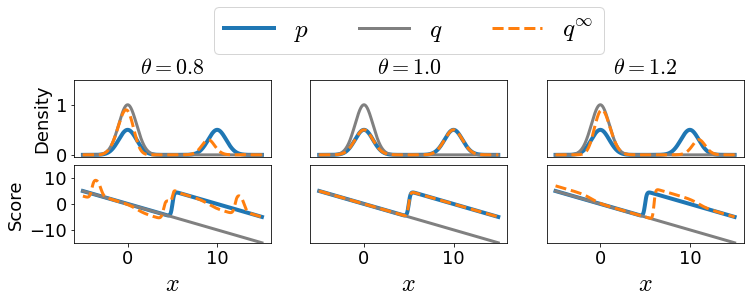

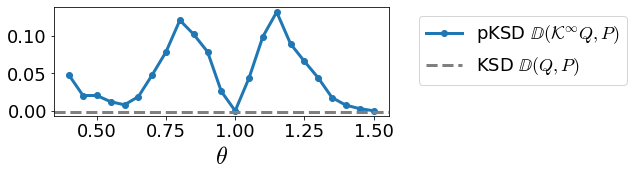

In [20]:
nu_delta_ratios_short = [0.8, 1.0, 1.2]
nu_delta_ratios = [float(x) for x in np.linspace(0.4, 1.5, 23)]

plot_scores3(
    log_prob_fn=log_prob_fn, 
    log_prob_off_fn=log_prob_off_fn,
    dist_class=LimitingDistribution,
    nu_delta_ratios_short=nu_delta_ratios_short,
    nu_delta_ratios=nu_delta_ratios,
    delta=delta,
    ksd_list=ksd_list,
    pksd_list=pksd_list,
    fd_list=fd_list,
    ylims1=[-0.05, 1.5],
    ylims2=[-15., 15.],
#     ylims1=[-1., 2.],
#     ylims2=[-4., 1.],
    plot_sample_density=True,
)